# CSIT456 Lab 5: Decision Trees
## Due date: April 17th, 2020

## Name:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns


## About the data set
We are going to predict the survival of Titanic passagers using Decision Tree. 

The dataset has 891 examples and 11 features + 1 target variable. 2 of the features are floats, 5 are integers and 5 are objects. Here is the short descriiption of the featues:

1. PassengerId: Unique Id of a passenger. 
2. survival:    Survival. 0 is not survived and 1 is survived
3. pclass:    Ticket class     
4. Name: name of the passenger
5. sex:    Sex. 0 is male and 1 is female
6. Age:    Age in years     
7. sibsp:    # of siblings / spouses aboard the Titanic     
8. parch:    # of parents / children aboard the Titanic     
9. ticket:    Ticket number     
10. fare:    Passenger fare     
11. cabin:    Cabin number     
12. embarked:    Port of Embarkation

In [2]:
titanic = pd.read_csv("titanic.csv")
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data cleanup

We need to do some cleanup: 
 * age has missing values, let's say wherever we have no value, we assume that the person is of mean age (this is not necessarily a good decision)
 * embarked has missing values, we add a dedicated category for unknown embarkation points
 * we need to convert the categorical values to numerical values 

In [4]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].mean())

def sex_to_numeric(x):
    if x=='male':
        return 0
    if x=='female':
        return 1
    else:
        return x

titanic["Sex"] = titanic["Sex"].apply(sex_to_numeric)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# this will break if run more than once
def embarked_to_numeric(x):
    if x=="S":
        return 0
    if x=="C":
        return 1
    if x=="Q":
        return 2
    else: 
        return 3
    
titanic["Embarked"] = titanic["Embarked"].apply(embarked_to_numeric)
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C85,1
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C123,0
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,NaN,0
5,6,0,3,"Moran, Mr. James",0,29.699118,0,0,330877,8.4583,NaN,2
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.000000,0,0,17463,51.8625,E46,0
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.000000,3,1,349909,21.0750,NaN,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.000000,0,2,347742,11.1333,NaN,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.000000,1,0,237736,30.0708,NaN,1


Let's work only with the numerical and categorical variables and omit passengerID, Name, Ticket and Cabin. These values could contain some information, but it's hard to make sense of them without more context.

In [6]:
features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
titanic = titanic[features]
titanic.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.000000,1,0,7.2500,0
1,1,1,1,38.000000,1,0,71.2833,1
2,1,3,1,26.000000,0,0,7.9250,0
3,1,1,1,35.000000,1,0,53.1000,0
4,0,3,0,35.000000,0,0,8.0500,0
5,0,3,0,29.699118,0,0,8.4583,2
6,0,1,0,54.000000,0,0,51.8625,0
7,0,3,0,2.000000,3,1,21.0750,0
8,1,3,1,27.000000,0,2,11.1333,0
9,1,2,1,14.000000,1,0,30.0708,1


In [7]:
X = titanic.loc[:,"Pclass":"Embarked"].values
y = titanic["Survived"].values.reshape(-1,1)

Now let's look at a decision tree that **ONLY operates on sex**! 

In [8]:
from sklearn.model_selection import train_test_split

sex = titanic["Sex"].values.reshape(-1,1)
sex_train, sex_test, y_train, y_test = train_test_split(sex, y, random_state=0)

In [9]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
tree_oneFeature = DecisionTreeClassifier()
tree_oneFeature.fit(sex_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [10]:
tree_onFeature_dot = export_graphviz(tree_oneFeature, out_file=None, feature_names=["sex"])
tree_onFeature_dot

'digraph Tree {\nnode [shape=box] ;\n0 [label="sex <= 0.5\\ngini = 0.474\\nsamples = 668\\nvalue = [410, 258]"] ;\n1 [label="gini = 0.311\\nsamples = 437\\nvalue = [353, 84]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="gini = 0.372\\nsamples = 231\\nvalue = [57, 174]"] ;\n0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n}'

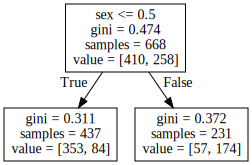

In [11]:
import graphviz
graphviz.Source(tree_onFeature_dot)

In [12]:
tree_oneFeature.score(sex_test,y_test)

0.7802690582959642

The accuracy is 78% when we just consider one feature. It's a good start. Now, let's try all the features in X.


## Question 1 [5 points] Data Preparing
**X** is the array of features and **y** is the one of predictor variable.

Split the data to train set (70%) and test set (30%) and don't allow the random selection. 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, stratify=digits.target)

## Question 2 [30 points] Create a Decision Tree with at most 3 depth
1. Create a decision tree and set the maximum depth to 3 [5 points]
2. Train the tree by the training set [5 points]
3. Plot the tree [15 points]
4. Caclulate the test accurancy of the tree [5 points]

In [21]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [25]:
tree_dot = export_graphviz(tree, out_file=None)

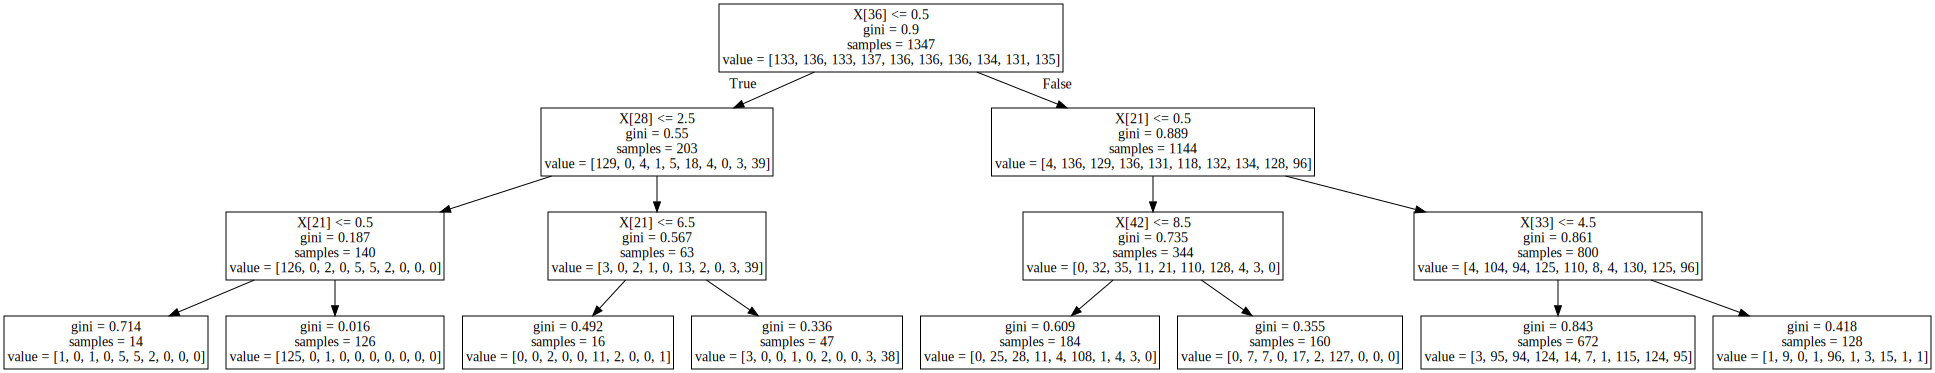

In [26]:
import graphviz
graphviz.Source(tree_dot)

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn import svm

scaled_svm = make_pipeline(StandardScaler(), SVC())
print(np.mean(cross_val_score(SVC(), X_train, y_train, cv=10)))
print(np.mean(cross_val_score(scaled_svm, X_train, y_train, cv=10)))

0.9866556108347153
0.9814427860696517


## Question 3 [15 points] Tunning the hyperparameter 
1. Apply GridSearchCV to find the best value of *max_leaf_nodes* from 2 to 19 using 10-fold CV and set the random state to 0. [5 points]
2. Print the best value of *max_leaf_nodes* and the test accurancy with the best value. [5 points]
3. Plot the tree and describe your observation. [5 points]|

In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_leaf_nodes':range(2, 19)}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv=(10), return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': range(2, 19)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score

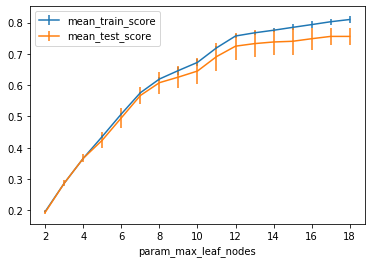

In [33]:

scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_max_leaf_nodes', y='mean_train_score', yerr='std_train_score', ax=plt.gca())
scores.plot(x='param_max_leaf_nodes', y='mean_test_score', yerr='std_test_score', ax=plt.gca())

In [34]:
scaled_svm = make_pipeline(StandardScaler(), SVC())
print(np.mean(cross_val_score(SVC(), X_train, y_train, cv=10)))
print(np.mean(cross_val_score(scaled_svm, X_train, y_train, cv=10)))

0.9866556108347153
0.9814427860696517
